In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
import os
import pathlib
from scipy import fftpack
import sys
from typing import Callable

curr_dir = pathlib.Path(os.getcwd())
prj_dir = curr_dir.parent.parent
sys.path.insert(0, str(prj_dir))
from grf_lab.models.kmod import cosmos

data_dir = curr_dir / "data"
figs_dir = curr_dir / "figs/grfs/" # Change this to your specification


for _path in [data_dir, figs_dir]:
    if not _path.exists():
        os.makedirs(_path, exist_ok=True)

We'll generate a set of parameters [A, B]

In [2]:
def make_power_spectrum(A: float, B: float) -> Callable[[ArrayLike], ArrayLike]:
    """Create a power spectrum function

    .. math::

    y(k) = A \cdot k^{-B}

    :param A: Amplitude
    :param B: The power law
    :return: A power law function.
    """
    return lambda k: (A * k) ** -B

In [3]:
# Generate a multi cosmology dataset    
n_sims = 5_000
n_pix = 64
box_dim = 1.
# pk_fn = lambda k: A * k ** -B

AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
param_names = ["A", "B"]

parameters = np.stack(
    [
        np.random.uniform(low=lower[0], high=upper[0], size=n_sims),
        np.random.uniform(low=lower[1], high=upper[1], size=n_sims)
    ], 
    axis=1
)

parameters.shape  # The training set disccused in the notebook

(5000, 2)

The parameters of the generated fields can be seen here

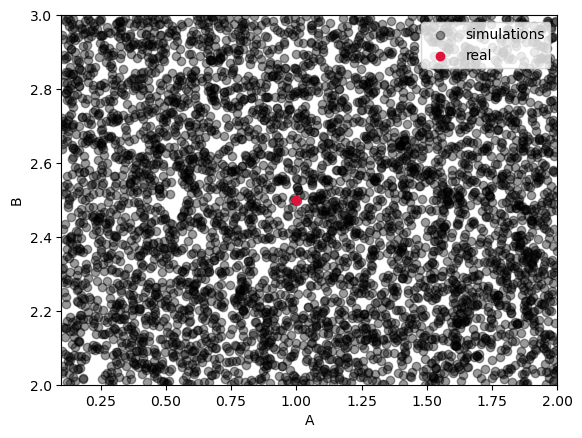

In [4]:
fig = plt.figure()
plt.scatter(*parameters.T, alpha=0.4, c="k", label="simulations")
plt.scatter(*AB.T, c="crimson", label="real")
plt.xlabel(param_names[0])
plt.xlim(lower[0], upper[0])
plt.ylabel(param_names[1])
plt.ylim(lower[1], upper[1])
plt.legend(loc="upper right")
plt.show()

In [5]:
fields = np.zeros((n_sims, n_pix, n_pix))
for i, (A, B) in enumerate(parameters):
    pk_fn = make_power_spectrum(A, B)
    fields[i] = cosmos.make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=i)
    print(f"\r{i=} {fields[i].max()=}, {fields[i].min()=}", end="")

# Unpack true parameters, parameterise power spectrum model using them
A, B = AB
pk_fn = make_power_spectrum(A, B)

# Make a measurement using the true parameters
data = cosmos.make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=128973874)
data.shape

i=4999 fields[i].max()=2.6249711938338605, fields[i].min()=-3.632541185236447544

(64, 64)

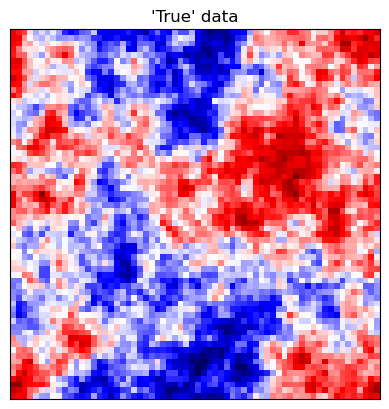

In [6]:
fig = plt.figure()
plt.imshow(data, cmap="seismic")
plt.title(f"'True' data")
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
np.save(os.path.join(data_dir, f"grfs_{n_pix=}.npy"), fields)
np.save(data_dir / f"grfs_{n_pix=}.npy", fields)
np.save(data_dir / f"data_{n_pix=}.npy", data)
np.save(data_dir / f"grfs_parameters_{n_pix=}.npy", parameters)

In [8]:
data.shape, fields.shape

((64, 64), (5000, 64, 64))

In [ ]:
assert False

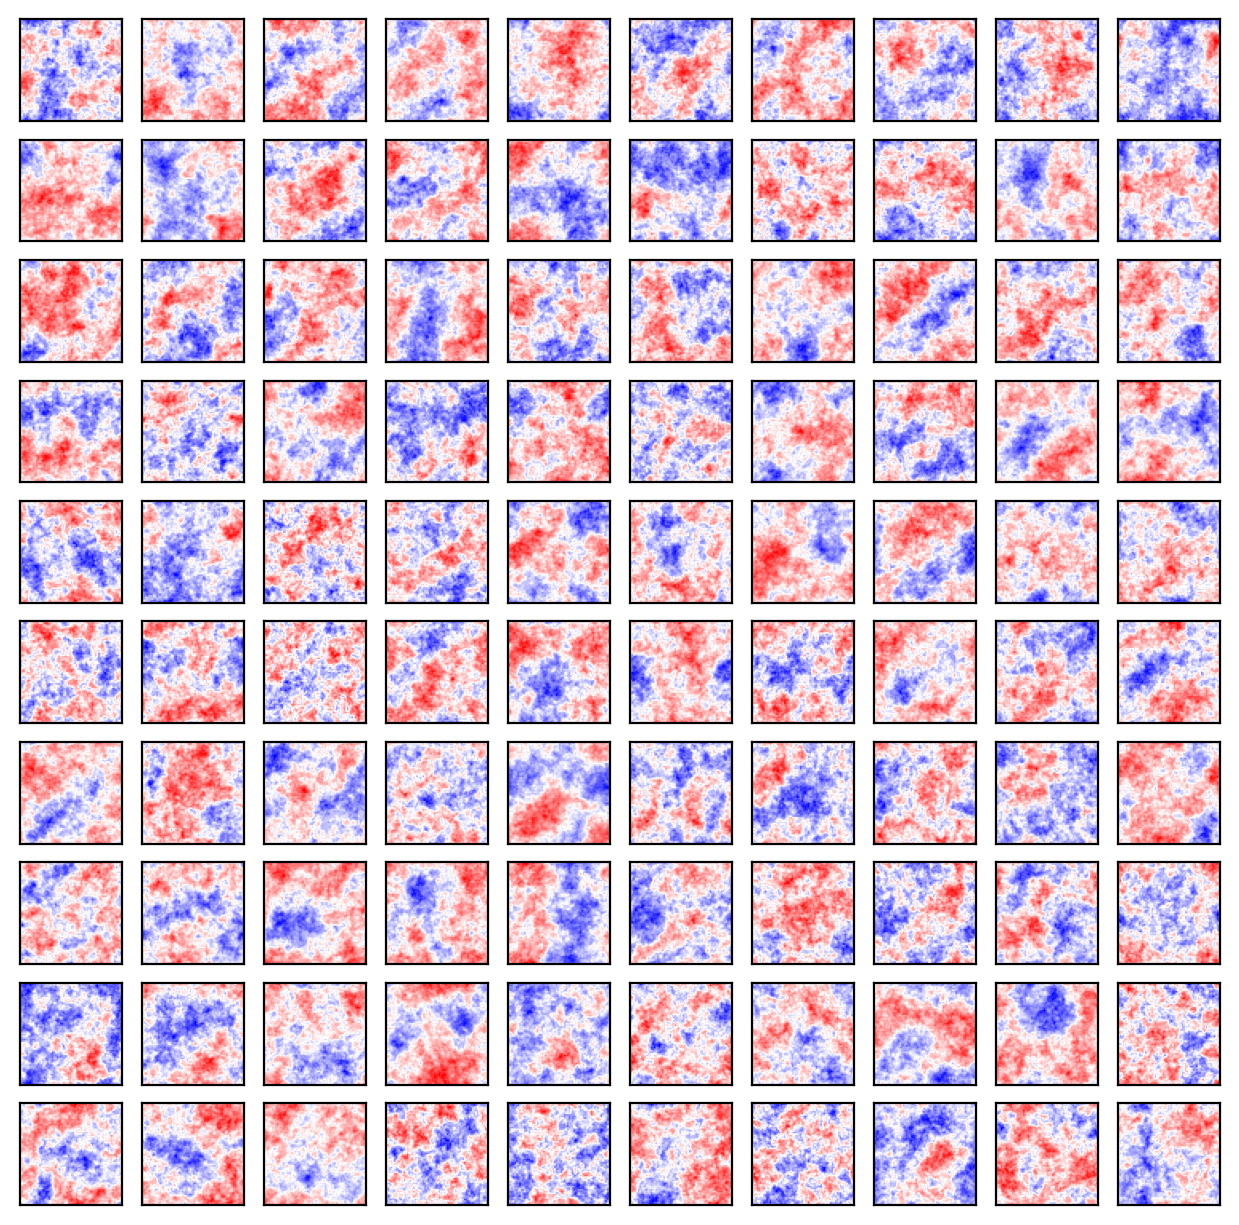

k.shape=(100,), pks.shape=(100, 100), pk.shape=(100,)


In [17]:
n_draws = 100

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = cosmos.make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = cosmos.power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    axd[str(i)].imshow(x, cmap="bwr")

plt.savefig(figs_dir / "grfs.png")
plt.show()

print(f"{k.shape=}, {pks.shape=}, {pk.shape=}")

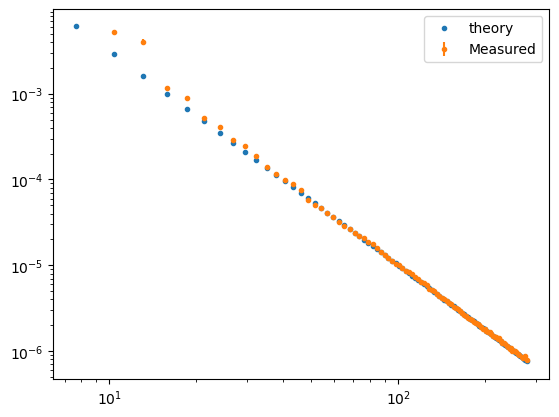

In [20]:
plt.figure()
plt.plot(k, pk_fn(k), marker=".", linestyle="", label="theory")
plt.errorbar(k, pks.mean(axis=0), yerr=pks.std(axis=0) / np.sqrt(n_draws), marker=".", linestyle="", label="Measured")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig(figs_dir / "Pk_fid.png", bbox_inches="tight")
plt.show()

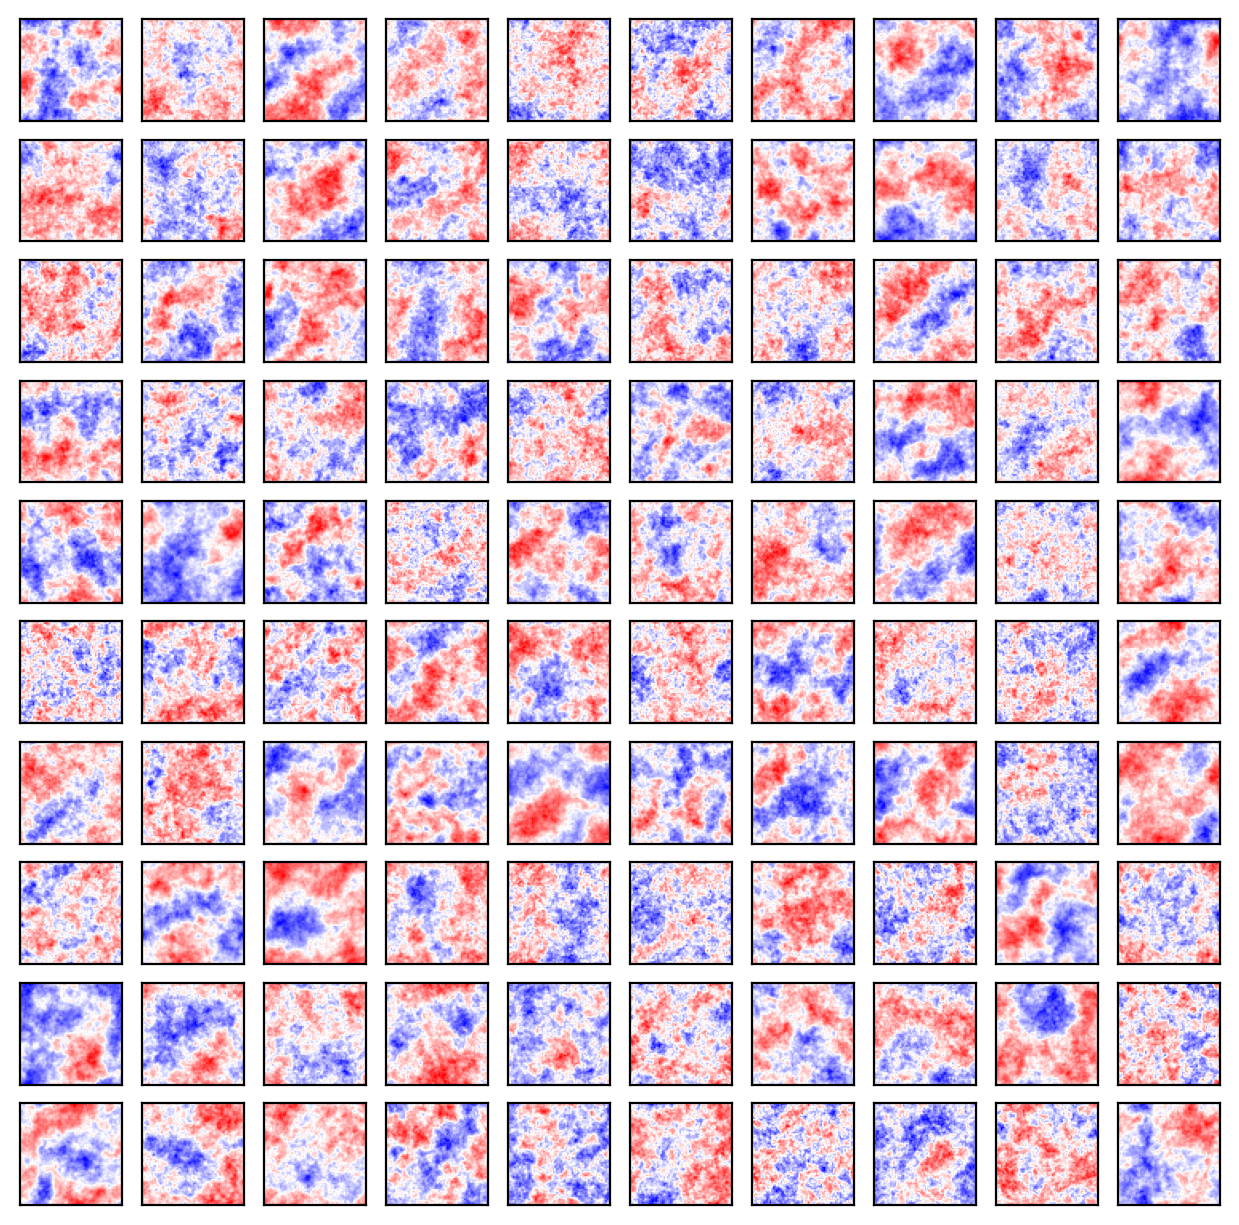

In [21]:
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks_multi_cos = np.zeros((n_draws, 100))
for i in range(n_draws):
    
    A, B = parameters[i]

    # Power spectrum model with sampled parameters
    pk_fn = lambda k: A * k ** -B

    x = cosmos.make_gaussian_random_field(
        n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = cosmos.power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks_multi_cos[i] = pk

    axd[str(i)].imshow(x, cmap="bwr")

plt.savefig(figs_dir / "multi_cosmo_grfs.png", bbox_inches="tight")
plt.show()

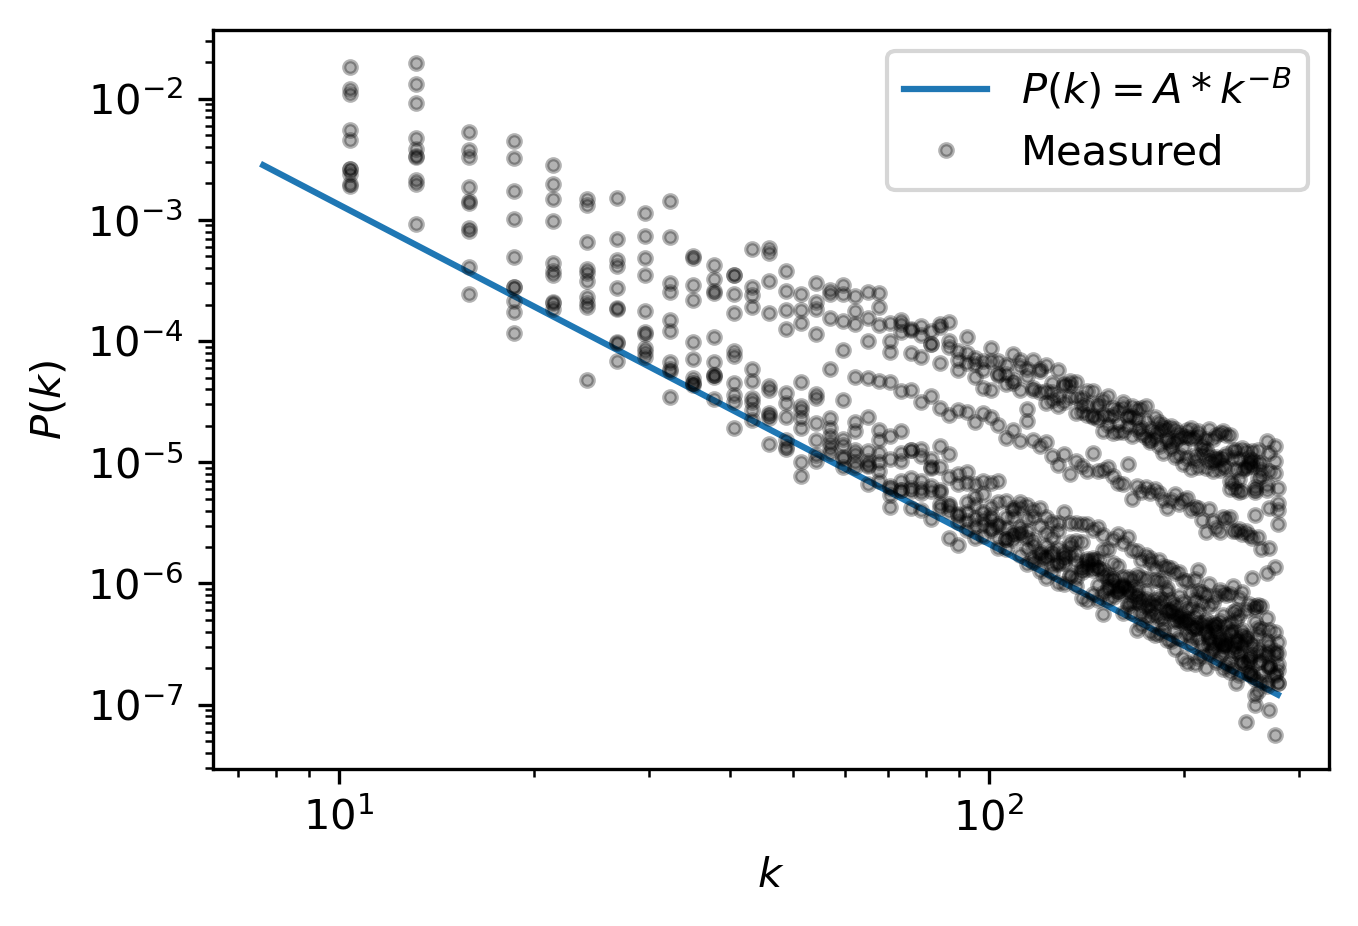

In [22]:
plt.figure(dpi=300, figsize=(4.8, 3.2))
plt.plot(k, pk_fn(k), label="$P(k)=A * k^{-B}$") 
for i in range(10):
    plt.plot(
        k, 
        pks_multi_cos[i], 
        marker=".", 
        linestyle="", 
        alpha=0.3,
        color="k", 
        label="Measured" if i == 0 else None
    )
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig(figs_dir / "multi_cosmo_pk.png", bbox_inches="tight")
plt.show()